In [1]:
import sys
import os
import warnings
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv
import google.generativeai as genai

if str(Path().resolve().parent) not in sys.path:
    sys.path.append(str(Path().resolve().parent))

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

warnings.filterwarnings("ignore", category=FutureWarning)

from src.config import random_seed, PREPROCESSED_BLOG_DATASET_PATH, CLASSIFICATION_MAP
from src.models_setup import gemini_2_flash, gemini_2_flash_lite, gemini_1_5_flash
from src.prompts import *
from src.output_formats import *
from src.helpers import extract_llm_assessment

# Data Processing

In [2]:
# Import data
blogs = pd.read_csv(PREPROCESSED_BLOG_DATASET_PATH)

# Split dataset into validation and test set
Xval, Xtest, yval_score, ytest_score = train_test_split(
    blogs.drop(columns=['normalized_engagement_score']), blogs["normalized_engagement_score"],
    test_size=0.4, random_state=random_seed)

# Same Xval, Xtest; new explained variable "engagement_level"
Xval, Xtest, yval_level, ytest_level = train_test_split(
    blogs.drop(columns=['engagement_level', 'normalized_engagement_score']), blogs["engagement_level"],
    test_size=0.4, random_state=random_seed)

print(f"Size of validation set, X: {Xval.shape}, y: {yval_score.shape}")
print(f"Size of test set, X: {Xtest.shape}, y: {ytest_score.shape}")

Size of validation set, X: (30, 11), y: (30,)
Size of test set, X: (20, 11), y: (20,)


In [3]:
# The best blog in dataset
best_blog_info = Xval.sort_values(["engagement_score"], ascending=False).head(1)
best_blog_index = best_blog_info.index[0]
best_blog_info = best_blog_info.reset_index(drop=True)
best_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score,blog_full_text
0,28,Towards Reasoning,https://medium.com/@saptarshichaudhuri/towards...,Saptarshi Chaudhuri,127,461,1,GSM-Symbolic: Understanding the Limitations of...,https://arxiv.org/pdf/2410.05229?source=post_p...,3.653543,# Towards Reasoning\nGlorified next token pred...


In [4]:
# The worst blog in dataset
worst_blog_info = Xval.sort_values(["engagement_score"], ascending=False).tail(1)
worst_blog_index = worst_blog_info.index[0]
worst_blog_info = worst_blog_info.reset_index(drop=True)
worst_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score,blog_full_text
0,18,SMoA: Improving Multi-agent Large Language Mod...,https://medium.com/@sulbha.jindal/smoa-improvi...,Sulbha Jain,41,0,0,SMoA: Improving Multi-agent Large Language Mod...,https://arxiv.org/pdf/2411.03284,0.0,# SMoA: Improving Multi-agent Large Language M...


In [5]:
blog_text = blogs.loc[16, "blog_full_text"]
print(blog_text)

# Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review
Paper — https://arxiv.org/pdf/2411.16646
Reinforcement Learning from Human Feedback (RLHF) has become a critical methodology for aligning large language models (LLMs) with human preferences. At the core of RLHF lies the reward model (RM), which is designed to evaluate model outputs by assigning scores that reflect their alignment with human judgments. These scores guide the optimization process during training, such as providing reward signals in Proximal Policy Optimization (PPO), thereby encouraging LLMs to generate responses that are more helpful, honest, and harmless. This iterative process enhances the practical quality of LLM outputs in real-world applications.

## Current challenge
Typically, reward models are trained using preference pairs and optimized through pairwise logistic loss to produce a scalar score for each response. However, this scalar output is often hard to interpret and underutili

In [6]:
best_blog = {
    "blog": best_blog_info.loc[0, "blog_full_text"],
    "score" : yval_score.loc[best_blog_index]
}
worst_blog = {
    "blog" : worst_blog_info.loc[0, "blog_full_text"],
    "score" : yval_score.loc[worst_blog_index]
}

In [7]:
excellent_blog_index = yval_level[yval_level == "Excellent"].index.min()
excellent_blog = blogs.loc[excellent_blog_index, "blog_full_text"]
with open("../data/examples/excellent_blog", "w", encoding="utf-8") as file:
    file.write(excellent_blog)

very_good_blog_index = yval_level[yval_level == "Very Good"].index.min()
very_good_blog = blogs.loc[very_good_blog_index, "blog_full_text"]
with open("../data/examples/very_good_blog", "w", encoding="utf-8") as file:
    file.write(very_good_blog)

good_blog_index = yval_level[yval_level == "Good"].index.min()
good_blog = blogs.loc[good_blog_index, "blog_full_text"]
with open("../data/examples/good_blog", "w", encoding="utf-8") as file:
    file.write(good_blog)

average_blog_index = yval_level[yval_level == "Average"].index.min()
average_blog = blogs.loc[average_blog_index, "blog_full_text"]
with open("../data/examples/average_blog", "w", encoding="utf-8") as file:
    file.write(average_blog)

bad_blog_index = yval_level[yval_level == "Bad"].index.min()
bad_blog = blogs.loc[bad_blog_index, "blog_full_text"]
with open("../data/examples/bad_blog", "w", encoding="utf-8") as file:
    file.write(bad_blog)

# Prompt Engineering

In [8]:
def test_prompt(prompt_template, model, input_variables):
    """Testing the operation of LLM with a given prompt template."""
    test_chain = prompt_template | model
    test_response = test_chain.invoke(input_variables)
    print(f"Usage metadata:\n{test_response.usage_metadata}")
    print(f"\nContent:\n{test_response.content}")

In [9]:
# One word answer
test_prompt(prompt_simple_answer, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1138, 'output_tokens': 3, 'total_tokens': 1141, 'input_token_details': {'cache_read': 0}}

Content:
Informative


In [10]:
# Adding numerical assessment
test_prompt(prompt_numeric_rating, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1143, 'output_tokens': 8, 'total_tokens': 1151, 'input_token_details': {'cache_read': 0}}

Content:
Informative 8/10


In [11]:
# Scale from 1 to 100 + short comment
test_prompt(prompt_short_comment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1154, 'output_tokens': 106, 'total_tokens': 1260, 'input_token_details': {'cache_read': 0}}

Content:
**Rating: 85/100**

**Comment:** This is a well-written and concise summary of the Critic-RM paper. It clearly explains the problem, the proposed solution, the methodology, and the key results. The use of bolding to highlight key terms and sections makes it easy to follow. The summary is informative and provides a good overview of the paper's contributions. Some minor improvements could include adding more details on the consistency-guided filtering technique, the summarization and ranking strategies.


In [12]:
# Emphasizing the importance of engagement
test_prompt(prompt_engagement_score, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1160, 'output_tokens': 100, 'total_tokens': 1260, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level: 55/100**

**Comment:** The blog post provides a clear and concise summary of a research paper. It's well-structured with headings and explanations, making it accessible to readers interested in the topic. However, it lacks interactive elements or features that encourage direct engagement, such as comment sections, polls, or embedded quizzes. Adding these elements could significantly boost its engagement level. Also I did not see any shares on social media about this post.


In [13]:
# Assessment based on several criteria
test_prompt(prompt_criteria, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1184, 'output_tokens': 359, 'total_tokens': 1543, 'input_token_details': {'cache_read': 0}}

Content:
**Assessment:**

*   **Readability:** The writing is generally clear and uses technical terms appropriately. However, the density of information and use of mathematical notation might make it challenging for readers without a background in machine learning. (Score: 7/10)
*   **Structure:** The blog post follows a logical structure (Introduction, Challenge, Methodology, Results, Summary). The use of headings and subheadings helps with organization. (Score: 8/10)
*   **Attractiveness of the Blog Title:** The title is descriptive but not particularly catchy. It clearly states the subject matter. (Score: 6/10)
*   **Clarity:** The explanation of the concepts is generally clear, but some sections might benefit from more concrete examples. The mathematical notation is explained but could be intimidating to some. (Score: 7/10)
*   **Audience Appeal:** The blog

In [14]:
# Separate assessment
test_prompt(prompt_separate_assessment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1211, 'output_tokens': 622, 'total_tokens': 1833, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's an analysis of the blog post's engagement level, broken down by criteria, followed by an overall assessment:

**Criterion Breakdown:**

*   **Readability (75/100):** The writing style is generally clear and uses proper terminology. However, it's geared towards a reader already familiar with LLMs, RLHF, and reward modeling. Someone completely new to the field might find it dense at times.

*   **Structure (85/100):** The blog post is well-structured with clear headings (Introduction, Current challenge, Methodology, Results, Summary, Appendix) that guide the reader through the information. The use of bullet points and formatting enhances readability.

*   **Informativeness (90/100):** The blog post provides a good overview of the paper and its contributions. It explains the problem being addressed, the methodology used, and the key results ob

In [15]:
# Add information about profile of the model
test_prompt(prompt_with_profile, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1239, 'output_tokens': 652, 'total_tokens': 1891, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's my assessment of the blog post based on your criteria, along with individual scores and an overall assessment.

**Individual Criterion Scores (out of 100):**

*   **Readability (75/100):** The writing is generally clear, but it does get bogged down in technical jargon at times. Someone without a background in RLHF might struggle with some sections. The use of headings and subheadings helps break up the text.
*   **Structure (85/100):** The blog follows a logical structure: introduction, problem, solution (methodology), results, and summary. This is a standard and effective way to present a paper review. The use of bullet points or numbered lists could further improve structure in some sections.
*   **Informativeness (80/100):** The blog provides a good overview of the paper's core concepts, methodology, and results. It explains the key idea

In [16]:
# Well-structured sections of the prompt
test_prompt(prompt_structured_sections, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1342, 'output_tokens': 851, 'total_tokens': 2193, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's an evaluation of the provided blog post based on the specified criteria:

**Individual Criterion Scores and Comments:**

*   **Readability (70/100):** The writing is generally clear, but the use of some technical jargon (e.g., "pairwise logistic loss," "knowledge distillation") without explicit definitions might hinder understanding for readers unfamiliar with the field.
*   **Structure (85/100):** The blog post follows a logical structure: introduction, challenge, methodology, results, and summary. The use of headings and subheadings improves organization and readability.
*   **Informativeness (80/100):** The blog post provides a good overview of the Critic-RM framework and its benefits. It highlights the key contributions of the research and explains the methodology in a reasonably accessible way.
*   **Attractiveness of the blog title (7

In [17]:
# 2-shot prompt
test_prompt(prompt_two_shots, gemini_2_flash, {
    "blog_text" : blog_text,
    "blog_ex1" : best_blog["blog"],
    "score_ex1" : best_blog["score"],
    "blog_ex2" : worst_blog["blog"],
    "score_ex2" : worst_blog["score"]
})

Usage metadata:
{'input_tokens': 3292, 'output_tokens': 256, 'total_tokens': 3548, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "overall_assessment": 65,
  "explanation": "The blog post provides a decent overview of the research paper, hitting the important points of the methodology and the results. However, the structure is a bit lacking, and the writing, while generally clear, could be more engaging. The title is adequate but not particularly attention-grabbing. The potential for discussion is moderate, as the topic is quite technical, but the blog does a solid job of summarizing the paper, providing a base for further discussion.",
  "possible_improvements": [
    "Improve the introduction to grab the reader's attention and more clearly state the importance of the research.",
    "Add more transition sentences between paragraphs and sections to improve the flow and readability.",
    "Break down the 'Methodology' section into smaller, more digestible chunks, possi

In [18]:
# 5-shot prompt with verbal classification
test_prompt(prompt_five_shots, gemini_2_flash, {
    "blog_text": blog_text,
    "excellent_blog": excellent_blog,
    "very_good_blog": very_good_blog,
    "good_blog": good_blog,
    "average_blog": average_blog,
    "bad_blog": bad_blog
})

Usage metadata:
{'input_tokens': 11803, 'output_tokens': 247, 'total_tokens': 12050, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "overall_engagement_level": "Good",
  "explanation": "The blog post provides a concise overview of a research paper, making it accessible to a broader audience interested in the field of LLMs and RLHF. It breaks down the paper's methodology, results, and significance in a clear and structured manner. However, the blog could benefit from more simplification of technical concepts and a more engaging title to attract readers.",
  "possible_improvements": [
    "Simplify technical jargon further to cater to a wider audience without deep expertise in LLMs or RLHF.",
    "Enhance the introduction with a more compelling hook to immediately grab the reader's attention.",
    "Use more real-world examples or analogies to explain abstract concepts and make them more relatable.",
    "Consider breaking down the 'Methodology' section into smaller, mor

In [19]:
# Zero-shot Chain-of-Thoughts
test_prompt(prompt_zero_cot, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1412, 'output_tokens': 750, 'total_tokens': 2162, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "analysis": {
    "readability": "The readability is moderate. While the language isn't overly complex, the frequent use of technical terms (RLHF, LLM, PPO, Critic-RM) without consistent, immediate explanation can make it difficult for a general audience to follow. Acronyms are defined upon first usage, which is good, but the density of these terms is high. Some sentences are also a bit long and could be broken down for better comprehension.",
    "structure": "The structure is reasonably well-organized. It follows a logical progression: introduction, problem statement (current challenge), proposed solution (methodology), results, and summary. The use of headings and subheadings improves navigability. However, some sections could benefit from further subdivision to enhance clarity.",
    "informativeness": "The blog provides a good overview 

In [20]:
# Generated knowledge
test_prompt(prompt_generated_knowledge, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1395, 'output_tokens': 569, 'total_tokens': 1964, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "key_analysis": {
    "readability": "Focuses on clear and concise language, avoiding jargon where possible. Uses headings and subheadings to break up text and improve flow.",
    "structure": "Employs a logical structure, starting with an introduction, outlining the problem, describing the methodology, presenting results, and concluding with a summary.",
    "informativeness": "Provides sufficient background information to understand the research, explains the methodology in detail, and highlights key findings.",
    "attractiveness_of_the_blog_title": "The title should be descriptive and intriguing, capturing the essence of the blog post and encouraging readers to click.",
    "clarity": "Ensures that the explanations are easy to understand, defining any technical terms or concepts that may be unfamiliar to the target audience.",
    "audi

In [21]:
# Meta prompt
test_prompt(prompt_meta, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1595, 'output_tokens': 861, 'total_tokens': 2456, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
    "Referenced blog to evaluate": "Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review",
    "Step 1": "Analyze the readability of the blog. Is the text easy to understand? Are the sentences clear and well-structured? The readability is somewhat challenging. While the sentences are generally well-structured, the density of technical terms and concepts related to LLMs and reinforcement learning creates a barrier for readers unfamiliar with the field. Jargon like 'Proximal Policy Optimization (PPO),' 'pairwise logistic loss,' and references to specific models without extensive explanation reduces readability.",
    "Step 2": "Evaluate the structure of the blog. Does it follow a logical flow? Are the sections well-organized? The blog follows a reasonably logical structure: Introduction, Current Challenge, Methodology

# Performance testing on a validation set

In [92]:
def show_scatter_plot(real_values, predicted_values):
    plt.scatter(real_values, predicted_values, color='blue')
    plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color='red', linestyle='--')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.title('Real vs Predicted values')
    plt.show()

In [93]:
# Models
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogEvaluation, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogEvaluation, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogEvaluation, include_raw=True)

## Numeric evaluation with two-shot prompt


### Gemini 2.0 Flash

In [ ]:
flash_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_structured,
                                        {
                                            "blog_ex1" : best_blog["blog"],
                                            "score_ex1" : best_blog["score"],
                                            "blog_ex2" : worst_blog["blog"],
                                            "score_ex2" : worst_blog["score"]
                                        })

In [96]:
flash_RMSE_val = metrics.root_mean_squared_error(yval_score, flash_assessment)
print(f"Root Mean Square Error on validation set: {flash_RMSE_val:.1f}")
flash_MAE_val = metrics.mean_absolute_error(yval_score, flash_assessment)
print(f"Mean Absolute Error on validation set: {flash_MAE_val:.1f}")

Root Mean Square Error on validation set: 42.8
Mean Absolute Error on validation set: 36.0


### Gemini 2.0 Flash-Lite

In [26]:
lite_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_lite_structured,
                                        {
                                            "blog_ex1" : best_blog["blog"],
                                            "score_ex1" : best_blog["score"],
                                            "blog_ex2" : worst_blog["blog"],
                                            "score_ex2" : worst_blog["score"]
                                        })

In [27]:
lite_RMSE_val = metrics.root_mean_squared_error(yval_score, lite_assessment)
print(f"Root Mean Square Error on validation set: {lite_RMSE_val:.1f}")
lite_MAE_val = metrics.mean_absolute_error(yval_score, lite_assessment)
print(f"Mean Absolute Error on validation set: {lite_MAE_val:.1f}")

Root Mean Square Error on validation set: 43.1
Mean Absolute Error on validation set: 37.1


### Gemini 1.5 Flash

In [28]:
flash1_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_1_5_flash_structured,
                                        {
                                            "blog_ex1" : best_blog["blog"],
                                            "score_ex1" : best_blog["score"],
                                            "blog_ex2" : worst_blog["blog"],
                                            "score_ex2" : worst_blog["score"]
                                        })

In [29]:
flash1_RMSE_val = metrics.root_mean_squared_error(yval_score, flash1_assessment)
print(f"Root Mean Square Error on validation set: {flash1_RMSE_val:.1f}")
flash1_MAE_val = metrics.mean_absolute_error(yval_score, flash1_assessment)
print(f"Mean Absolute Error on validation set: {flash1_MAE_val:.1f}")

Root Mean Square Error on validation set: 47.4
Mean Absolute Error on validation set: 40.9


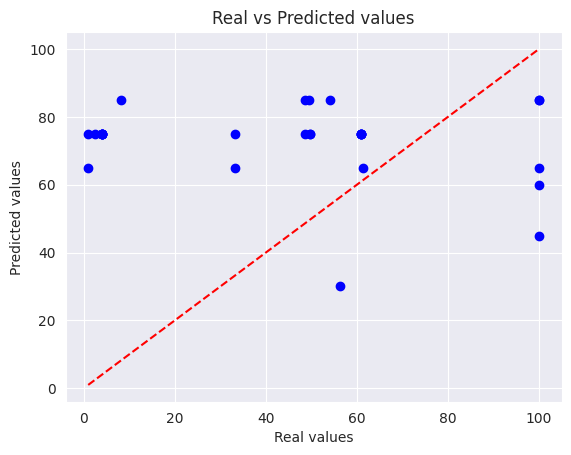

In [30]:
show_scatter_plot(yval_score, flash1_assessment)

## Normalized numeric evaluation with two-shot prompt

### Gemini 2.0 Flash

In [89]:
flash_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
scaled_flash_assessment = flash_assessment_scaler.fit_transform(flash_assessment.values.reshape(-1, 1))
flash_RMSE_val_scaled = metrics.root_mean_squared_error(yval_score, scaled_flash_assessment)
print(f"Root Mean Square Error on validation set after MinMax normalization of LLM output: {flash_RMSE_val_scaled:.1f}")
flash_MAE_val_scaled = metrics.mean_absolute_error(yval_score, scaled_flash_assessment)
print(f"Mean Absolute Error on validation set after MinMax normalization of LLM output: {flash_MAE_val_scaled:.1f}")

Root Mean Square Error on validation set after MinMax normalization of LLM output: 36.5
Mean Absolute Error on validation set after MinMax normalization of LLM output: 29.7


### Gemini 2.0 Flash-Lite

In [90]:
lite_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
scaled_lite_assessment = lite_assessment_scaler.fit_transform(lite_assessment.values.reshape(-1, 1))
lite_RMSE_val_scaled = metrics.root_mean_squared_error(yval_score, scaled_lite_assessment)
print(f"Root Mean Square Error on validation set after MinMax normalization of LLM output: {lite_RMSE_val_scaled:.1f}")
lite_MAE_val_scaled = metrics.mean_absolute_error(yval_score, scaled_lite_assessment)
print(f"Mean Absolute Error on validation set after MinMax normalization of LLM output: {lite_MAE_val_scaled:.1f}")

Root Mean Square Error on validation set after MinMax normalization of LLM output: 47.7
Mean Absolute Error on validation set after MinMax normalization of LLM output: 40.6


### Gemini 1.5 Flash

In [91]:
flash1_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
scaled_flash1_assessment = flash1_assessment_scaler.fit_transform(flash1_assessment.values.reshape(-1, 1))
flash1_RMSE_val_scaled = metrics.root_mean_squared_error(yval_score, scaled_flash1_assessment)
print(f"Root Mean Square Error on validation set after MinMax normalization of LLM output: {flash1_RMSE_val_scaled:.1f}")
flash1_MAE_val_scaled = metrics.mean_absolute_error(yval_score, scaled_flash1_assessment)
print(f"Mean Absolute Error on validation set after MinMax normalization of LLM output (Flash 1.5): {flash1_MAE_val_scaled:.1f}")

Root Mean Square Error on validation set after MinMax normalization of LLM output: 54.6
Mean Absolute Error on validation set after MinMax normalization of LLM output: 47.5


## Classification with five-shot prompt

In [34]:
# Models
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassification, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassification, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassification, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_structured,
                                            examples=
                                            {
                                                "excellent_blog" : excellent_blog,
                                                "very_good_blog" : very_good_blog,
                                                "good_blog" : good_blog,
                                                "average_blog" : average_blog,
                                                "bad_blog" : bad_blog
                                            })

In [36]:
flash_accuracy = metrics.accuracy_score(yval_level, flash_classification)
print(f"Accuracy score on validation set: {flash_accuracy * 100:.2f}%")

flash_RMSE_val_verbal = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash_classification.map(CLASSIFICATION_MAP))
flash_MAE_val_verbal = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {flash_RMSE_val_verbal:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {flash_MAE_val_verbal:.1f}")

Accuracy score on validation set: 46.67%
Root Mean Square Error on validation set after using the verbal classification: 1.3
Mean Absolute Error on validation set after using verbal classification: 0.8


### Gemini 2.0 Flash-Lite

In [37]:
lite_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_lite_structured,
                                            examples=
                                            {
                                                "excellent_blog" : excellent_blog,
                                                "very_good_blog" : very_good_blog,
                                                "good_blog" : good_blog,
                                                "average_blog" : average_blog,
                                                "bad_blog" : bad_blog
                                            })

In [38]:
lite_accuracy = metrics.accuracy_score(yval_level, lite_classification)
print(f"Accuracy score on validation set: {lite_accuracy * 100:.2f}%")

lite_RMSE_val_verbal = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), lite_classification.map(CLASSIFICATION_MAP))
lite_MAE_val_verbal = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), lite_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {lite_RMSE_val_verbal:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {lite_MAE_val_verbal:.1f}")

Accuracy score on validation set: 43.33%
Root Mean Square Error on validation set after using the verbal classification: 1.5
Mean Absolute Error on validation set after using verbal classification: 1.1


### Gemini 1.5 Flash

In [39]:
flash1_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_1_5_flash_structured,
                                            examples=
                                            {
                                                "excellent_blog" : excellent_blog,
                                                "very_good_blog" : very_good_blog,
                                                "good_blog" : good_blog,
                                                "average_blog" : average_blog,
                                                "bad_blog" : bad_blog
                                            })

In [40]:
flash1_accuracy = metrics.accuracy_score(yval_level, flash1_classification)
print(f"Accuracy score on validation set: {flash1_accuracy * 100:.2f}%")

flash1_RMSE_val_verbal = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash1_classification.map(CLASSIFICATION_MAP))
flash1_MAE_val_verbal = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash1_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using the verbal classification: {flash1_RMSE_val_verbal:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {flash1_MAE_val_verbal:.1f}")

Accuracy score on validation set: 23.33%
Root Mean Square Error on validation set after using the verbal classification: 1.4
Mean Absolute Error on validation set after using verbal classification: 1.1


## Classification with Chain-of-Thoughts prompt

In [41]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationCoT, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationCoT, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationCoT, include_raw=True)

### Gemini 2.0 Flash

In [42]:
flash_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_2_flash_structured, examples={})

In [101]:
flash_cot_accuracy = metrics.accuracy_score(yval_level, flash_cot_classification)
print(f"Accuracy score on validation set: {flash_cot_accuracy * 100:.2f}%")

flash_RMSE_val_cot = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash_cot_classification.map(CLASSIFICATION_MAP))
flash_MAE_val_cot = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash_cot_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Chain-of-Thoughts: {flash_RMSE_val_cot:.1f}")
print(f"Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: {flash_MAE_val_cot:.1f}")

Accuracy score on validation set: 13.33%
Root Mean Square Error on validation set after using Chain-of-Thoughts: 1.6
Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: 1.4


### Gemini 2.0 Flash-Lite

In [44]:
lite_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_2_flash_lite_structured, examples={})

In [102]:
lite_cot_accuracy = metrics.accuracy_score(yval_level, lite_cot_classification)
print(f"Accuracy score on validation set: {lite_cot_accuracy * 100:.2f}%")

lite_RMSE_val_cot = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), lite_cot_classification.map(CLASSIFICATION_MAP))
lite_MAE_val_cot = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), lite_cot_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Chain-of-Thoughts: {lite_RMSE_val_cot:.1f}")
print(f"Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: {lite_MAE_val_cot:.1f}")

Accuracy score on validation set: 26.67%
Root Mean Square Error on validation set after using Chain-of-Thoughts: 1.8
Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: 1.4


### Gemini 1.5 Flash

In [ ]:
flash1_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_1_5_flash_structured, examples={})

In [103]:
flash1_cot_accuracy = metrics.accuracy_score(yval_level, flash1_cot_classification)
print(f"Accuracy score on validation set: {flash1_cot_accuracy * 100:.2f}%")

flash1_RMSE_val_cot = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash1_cot_classification.map(CLASSIFICATION_MAP))
flash1_MAE_val_cot = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash1_cot_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Chain-of-Thoughts: {flash1_RMSE_val_cot:.1f}")
print(f"Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: {flash1_MAE_val_cot:.1f}")

Accuracy score on validation set: 16.67%
Root Mean Square Error on validation set after using Chain-of-Thoughts: 1.9
Mean Absolute Error on validation set after using verbal Chain-of-Thoughts: 1.6


## Classification with generated knowledge prompt

In [48]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationGK, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationGK, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationGK, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_2_flash_structured, examples={})

In [50]:
flash_gk_accuracy = metrics.accuracy_score(yval_level, flash_gk_classification)
print(f"Accuracy score on validation set: {flash_gk_accuracy * 100:.2f}%")

flash_RMSE_val_gk = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash_gk_classification.map(CLASSIFICATION_MAP))
flash_MAE_val_gk = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash_gk_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using generated knowledge: {flash_RMSE_val_gk:.1f}")
print(f"Mean Absolute Error on validation set after using generated knowledge: {flash_MAE_val_gk:.1f}")

Accuracy score on validation set: 16.67%
Root Mean Square Error on validation set after using generated knowledge: 1.6
Mean Absolute Error on validation set after using generated knowledge: 1.4


### Gemini 2.0 Flash-Lite

In [51]:
lite_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_2_flash_lite_structured, examples={})

In [52]:
lite_gk_accuracy = metrics.accuracy_score(yval_level, lite_gk_classification)
print(f"Accuracy score on validation set: {lite_gk_accuracy * 100:.2f}%")

lite_RMSE_val_gk = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), lite_gk_classification.map(CLASSIFICATION_MAP))
lite_MAE_val_gk = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), lite_gk_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using generated knowledge: {lite_RMSE_val_gk:.1f}")
print(f"Mean Absolute Error on validation set after using generated knowledge: {lite_MAE_val_gk:.1f}")

Accuracy score on validation set: 20.00%
Root Mean Square Error on validation set after using generated knowledge: 1.8
Mean Absolute Error on validation set after using generated knowledge: 1.5


### Gemini 1.5 Flash

In [53]:
flash1_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_1_5_flash_structured, examples={})

In [54]:
flash1_gk_accuracy = metrics.accuracy_score(yval_level, flash1_gk_classification)
print(f"Accuracy score on validation set: {flash1_gk_accuracy * 100:.2f}%")

flash1_RMSE_val_gk = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash1_gk_classification.map(CLASSIFICATION_MAP))
flash1_MAE_val_gk = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash1_gk_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using generated knowledge: {flash1_RMSE_val_gk:.1f}")
print(f"Mean Absolute Error on validation set after using generated knowledge: {flash1_MAE_val_gk:.1f}")

Accuracy score on validation set: 13.33%
Root Mean Square Error on validation set after using generated knowledge: 1.6
Mean Absolute Error on validation set after using generated knowledge: 1.4


## Classification with Meta prompt

In [55]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationMP, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationMP, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationMP, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_2_flash_structured, examples={})

In [104]:
flash_mp_accuracy = metrics.accuracy_score(yval_level, flash_mp_classification)
print(f"Accuracy score on validation set: {flash_mp_accuracy * 100:.2f}%")

flash_RMSE_val_mp = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash_mp_classification.map(CLASSIFICATION_MAP))
flash_MAE_val_mp = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash_mp_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Meta prompt: {flash_RMSE_val_mp:.1f}")
print(f"Mean Absolute Error on validation set after using Meta prompt: {flash_MAE_val_mp:.1f}")

Accuracy score on validation set: 23.33%
Root Mean Square Error on validation set after using Meta prompt: 1.6
Mean Absolute Error on validation set after using Meta prompt: 1.3


### Gemini 2.0 Flash-Lite

In [ ]:
lite_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_2_flash_lite_structured, examples={})

In [105]:
lite_mp_accuracy = metrics.accuracy_score(yval_level, lite_mp_classification)
print(f"Accuracy score on validation set: {lite_mp_accuracy * 100:.2f}%")

lite_RMSE_val_mp = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), lite_mp_classification.map(CLASSIFICATION_MAP))
lite_MAE_val_mp = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), lite_mp_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Meta prompt: {lite_RMSE_val_mp:.1f}")
print(f"Mean Absolute Error on validation set after using Meta prompt: {lite_MAE_val_mp:.1f}")

Accuracy score on validation set: 23.33%
Root Mean Square Error on validation set after using Meta prompt: 1.7
Mean Absolute Error on validation set after using Meta prompt: 1.4


### Gemini 1.5 Flash

In [60]:
flash1_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_1_5_flash_structured, examples={})

In [106]:
flash1_mp_accuracy = metrics.accuracy_score(yval_level, flash1_mp_classification)
print(f"Accuracy score on validation set: {flash1_mp_accuracy * 100:.2f}%")

flash1_RMSE_val_mp = metrics.root_mean_squared_error(yval_level.map(CLASSIFICATION_MAP), flash1_mp_classification.map(CLASSIFICATION_MAP))
flash1_MAE_val_mp = metrics.mean_absolute_error(yval_level.map(CLASSIFICATION_MAP), flash1_mp_classification.map(CLASSIFICATION_MAP))
print(f"Root Mean Square Error on validation set after using Meta prompt: {flash1_RMSE_val_mp:.1f}")
print(f"Mean Absolute Error on validation set after using Meta prompt: {flash1_MAE_val_mp:.1f}")

Accuracy score on validation set: 10.00%
Root Mean Square Error on validation set after using Meta prompt: 1.7
Mean Absolute Error on validation set after using Meta prompt: 1.5


# Results

In [107]:
def show_metric_bar_plot(models, values, metric):
    plt.bar(models, values, color='orange')
    plt.title(f'{metric} comparison for different models')
    plt.ylabel(f'{metric}')
    plt.ylim(min(values) - 5, max(values) + 1)
    plt.show()

def show_metric_heat_map(data, metric, reverse_color=True):
    sns.heatmap(data.set_index('Model'), annot=True, cmap='coolwarm_r' if reverse_color else 'coolwarm', fmt='.2f')
    plt.title(f'Heatmap of {metric}')
    plt.xticks(rotation=45)
    plt.show()

## Numeric evaluation with two-shot prompt

In [108]:
num_eval = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'RMSE': [flash_RMSE_val, lite_RMSE_val, flash1_RMSE_val],
    'MAE': [flash_MAE_val, lite_MAE_val, flash1_MAE_val],
}
num_eval_table = pd.DataFrame(num_eval).round(2)
num_eval_table

,Model,RMSE,MAE
0,Gemini 2.0 Flash,42.78,35.99
1,Gemini 2.0 Flash-Lite,43.11,37.09
2,Gemini 1.5 Flash,47.35,40.93


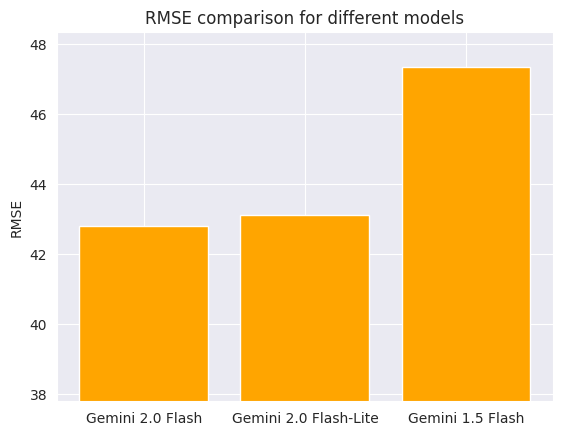

In [109]:
show_metric_bar_plot(num_eval_table["Model"], num_eval_table["RMSE"], "RMSE")

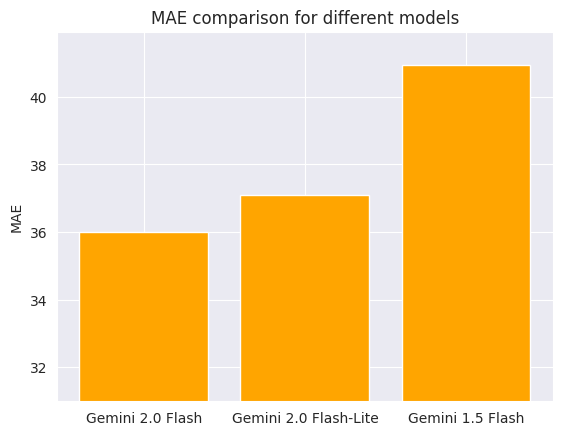

In [110]:
show_metric_bar_plot(num_eval_table["Model"], num_eval_table["MAE"], "MAE")

## Normalized numeric evaluation with two-shot prompt

In [111]:
norm_num_eval = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'RMSE': [flash_RMSE_val_scaled, lite_RMSE_val_scaled, flash1_RMSE_val_scaled],
    'MAE': [flash_MAE_val_scaled, lite_MAE_val_scaled, flash1_MAE_val_scaled],
}
norm_num_eval_table = pd.DataFrame(norm_num_eval).round(2)
norm_num_eval_table

,Model,RMSE,MAE
0,Gemini 2.0 Flash,36.53,29.70
1,Gemini 2.0 Flash-Lite,47.66,40.63
2,Gemini 1.5 Flash,54.60,47.53


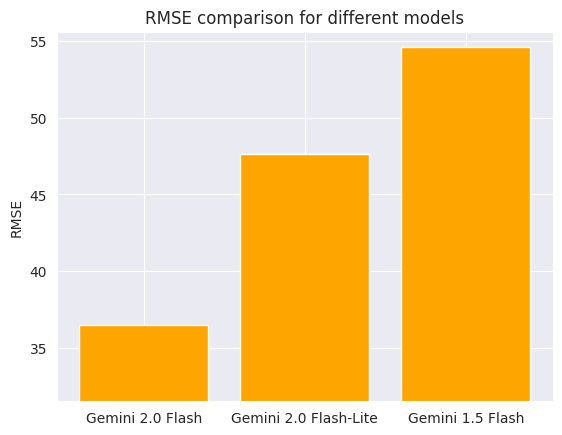

In [112]:
show_metric_bar_plot(norm_num_eval_table["Model"], norm_num_eval_table["RMSE"], "RMSE")

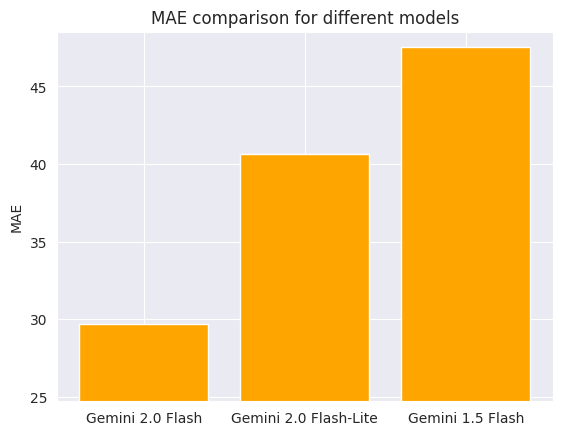

In [113]:
show_metric_bar_plot(norm_num_eval_table["Model"], norm_num_eval_table["MAE"], "MAE")

## Classification RMSE

In [114]:
clas_eval_RMSE = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'Five-shot prompt': [flash_RMSE_val_verbal, lite_RMSE_val_verbal, flash1_RMSE_val_verbal],
    'Zero-shot CoT prompt': [flash_RMSE_val_cot, lite_RMSE_val_cot, flash1_RMSE_val_cot],
    'Generated Knowledge prompt': [flash_RMSE_val_gk, lite_RMSE_val_gk, flash1_RMSE_val_gk],
    'Meta prompt': [flash_RMSE_val_mp, lite_RMSE_val_mp, flash1_RMSE_val_mp]
}
clas_eval_RMSE_table = pd.DataFrame(clas_eval_RMSE).round(2)
clas_eval_RMSE_table

,Model,Five-shot prompt,Zero-shot CoT prompt,Generated Knowledge prompt,Meta prompt
0,Gemini 2.0 Flash,1.28,1.56,1.63,1.56
1,Gemini 2.0 Flash-Lite,1.51,1.78,1.77,1.72
2,Gemini 1.5 Flash,1.44,1.94,1.59,1.74


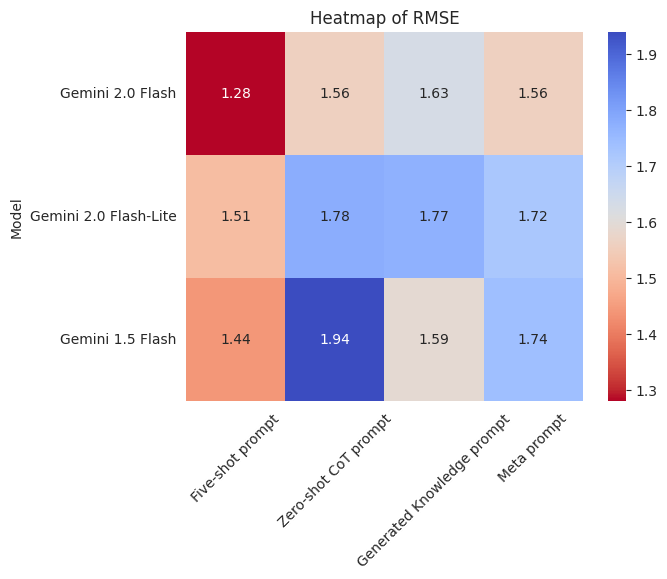

In [115]:
show_metric_heat_map(clas_eval_RMSE_table, "RMSE")

## Classification MAE

In [116]:
clas_eval_MAE = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'Five-shot prompt': [flash_MAE_val_verbal, lite_MAE_val_verbal, flash1_MAE_val_verbal],
    'Zero-shot CoT prompt': [flash_MAE_val_cot, lite_MAE_val_cot, flash1_MAE_val_cot],
    'Generated Knowledge prompt': [flash_MAE_val_gk, lite_MAE_val_gk, flash1_MAE_val_gk],
    'Meta prompt': [flash_MAE_val_mp, lite_MAE_val_mp, flash1_MAE_val_mp]
}
clas_eval_MAE_table = pd.DataFrame(clas_eval_MAE).round(2)
clas_eval_MAE_table

,Model,Five-shot prompt,Zero-shot CoT prompt,Generated Knowledge prompt,Meta prompt
0,Gemini 2.0 Flash,0.83,1.37,1.40,1.30
1,Gemini 2.0 Flash-Lite,1.07,1.37,1.47,1.37
2,Gemini 1.5 Flash,1.13,1.63,1.40,1.50


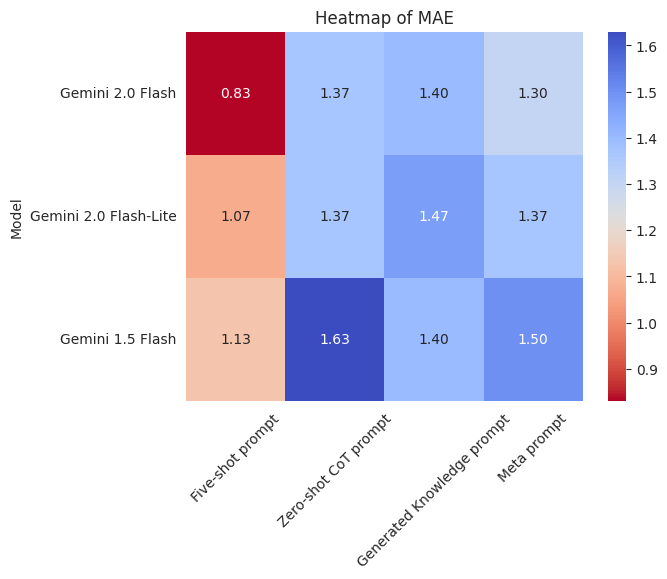

In [117]:
show_metric_heat_map(clas_eval_MAE_table, "MAE")

## Classification accuracy

In [118]:
clas_eval_acc = {
    'Model': ['Gemini 2.0 Flash', 'Gemini 2.0 Flash-Lite', 'Gemini 1.5 Flash'],
    'Five-shot prompt': [flash_accuracy, lite_accuracy, flash1_accuracy],
    'Zero-shot CoT prompt': [flash_cot_accuracy, lite_cot_accuracy, flash1_cot_accuracy],
    'Generated Knowledge prompt': [flash_gk_accuracy, lite_gk_accuracy, flash1_gk_accuracy],
    'Meta prompt': [flash_mp_accuracy, lite_mp_accuracy, flash1_mp_accuracy]
}
clas_eval_acc_table = pd.DataFrame(clas_eval_acc).round(3)
clas_eval_acc_table

,Model,Five-shot prompt,Zero-shot CoT prompt,Generated Knowledge prompt,Meta prompt
0,Gemini 2.0 Flash,0.467,0.133,0.167,0.233
1,Gemini 2.0 Flash-Lite,0.433,0.267,0.200,0.233
2,Gemini 1.5 Flash,0.233,0.167,0.133,0.100


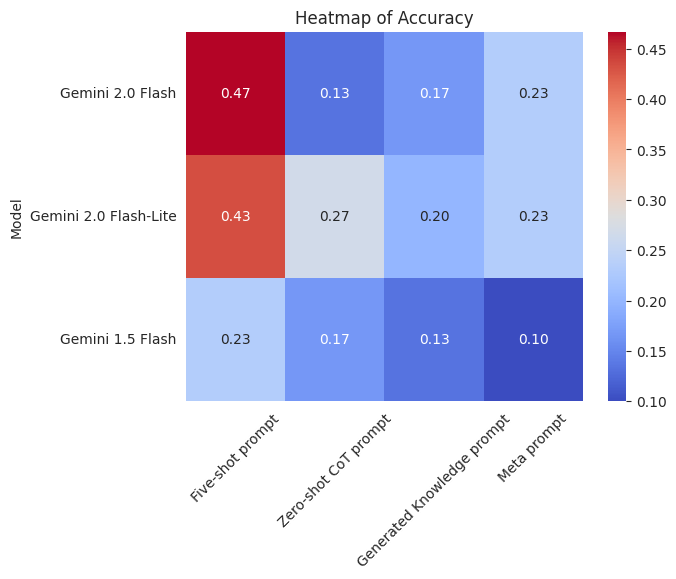

In [119]:
show_metric_heat_map(clas_eval_acc_table, "Accuracy", reverse_color=False)